In [2]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.feature_selection import SelectKBest,f_regression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from random import sample
# 导入数据集
# path = r'D:\20231017(仿真卤水)\for_ml\weighted\all.csv'
# label_path = r'D:\20231017(仿真卤水)\for_ml\weighted\alllab.csv'
# wl_path = r'D:\20231017(仿真卤水)\for_ml\weighted\wl.csv'
path = r'D:\20240412\nm\all.csv'
label_path = r'D:\20240412\alllab.csv'
wl_path = r'D:\20240412\wl.csv'
slice = 12200
data = pd.read_csv(path,header=None).values.astype(np.float32)[:,slice-2048:slice]
label = pd.read_csv(label_path,header=None).values.astype(np.float32)

scaler = MinMaxScaler()
label_scaler = MinMaxScaler()
# data = scaler.fit_transform(data)
# label = label_scaler.fit_transform(label)


In [3]:
new_feat_size = 300
mean_times = 10
new_lab = []
new_feat = []
######### make new feat ####################
unique_lab = np.unique(label)
for labs in unique_lab:
    index = np.isin(label,labs).reshape(-1)
    unique_feat = data[index,:]
    for _ in range(new_feat_size):
        new_feat.append(np.mean(unique_feat[sample(range(0,len(unique_feat[:,0]-1)),mean_times),:],axis = 0))
        new_lab.append(labs)

data = np.array(new_feat)
label = np.array(new_lab).reshape(-1,1)

In [4]:
##################特征选择##################
selector = SelectKBest(f_regression, k=10)
data = selector.fit_transform(data, label.ravel())

In [6]:
unique = np.unique(label)
model = XGBRegressor(
    booster = 'gbtree',
    n_estimators=400,
    learning_rate=0.01,
    subsample=0.9,
    colsample_bytree=1, 
    max_depth=9,
    gamma=0.05,
    objective= 'reg:squarederror'#'reg:squarederror'
)

rmse = []
r2 = []
mae = []
predictions = []
train_prediction = []
y_test_lab = []
y_train_lab = []
#########cv############
unique_lab = unique[1:-1]
# unique_lab = unique
for test_select in range(len(unique_lab)):
    test_select = unique_lab[test_select]
    test_index = np.isin(label,test_select).reshape(-1)
    X_test = data[test_index,:]
    y_test = label[test_index]
    X_train = data[~test_index,:]
    y_train = label[~test_index]

    eval_set = [(X_train, y_train), (X_test, y_test)]

    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    train_prediction.append(model.predict(X_train).reshape(-1,1))
    predictions.append(model.predict(X_test).reshape(-1,1))
    y_train_lab.append(y_train.reshape(-1,1)) 
    y_test_lab.append(y_test.reshape(-1,1)) 
    print(test_select)
    # model.fit(X_train, y_train)
    # scores = cross_val_score(model, X_train, y_train,cv=10)
    # print("Mean cross-validation score: %.2f" % scores.mean())

30.0
50.0
70.0
110.0
150.0
200.0
250.0
300.0
400.0
500.0
700.0


In [ ]:
for i in range(len(predictions)):
    if i == 0 :
        a = predictions[i]
        b = y_test_lab[i]
    else:
        a = np.vstack((a,predictions[i]))
        b = np.vstack((b,y_test_lab[i]))

# predictions = label_scaler.inverse_transform(a)
# y_test = label_scaler.inverse_transform(b)

predictions = a
y_test = b

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("RMSE: %f" % (rmse))
print("R_Squared Score : %f" % (r2))
print("MAE: %f" % (mae))

RMSE: 99.379646
R_Squared Score : 0.754704
MAE: 66.544769


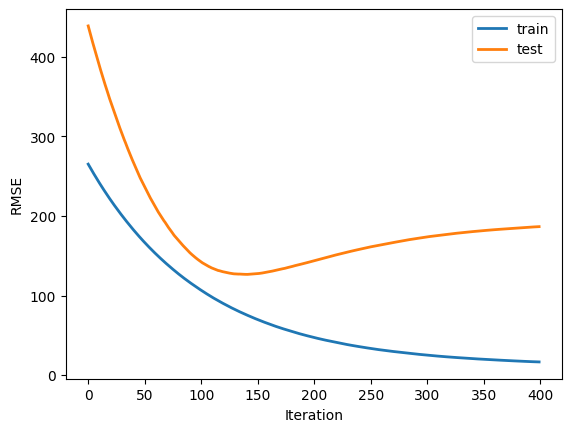

In [ ]:
######################################之前是CV#################################
# 训练模型并指定评估数据集

# 绘制损失曲线

plt.figure(1)
plt.plot(model.evals_result()['validation_0']['rmse'], label='train', linewidth=2)
plt.plot(model.evals_result()['validation_1']['rmse'], label='test', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('Loss.png')
plt.show()


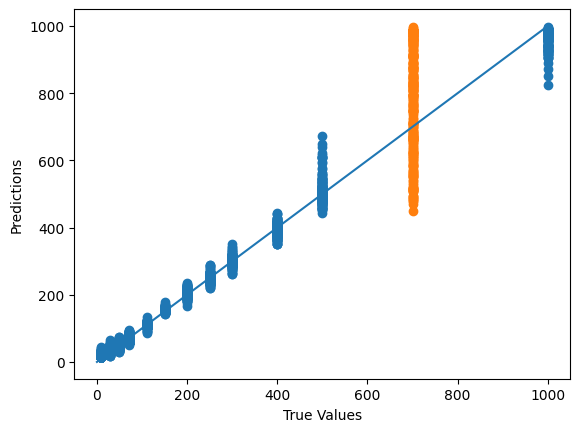

In [ ]:
predictions = model.predict(X_test).reshape(-1,1)
plt.figure(2)
plt.scatter(
            y_train.reshape(-1, 1),model.predict(X_train).reshape(-1,1))
plt.scatter(
            y_test.reshape(-1, 1)[-300:],model.predict(X_test).reshape(-1,1))
x = y = [0,1000]
plt.plot(x,y)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
a = np.vstack((y_train.reshape(-1, 1),y_test.reshape(-1, 1)[-300:]))
b = np.vstack((model.predict(X_train).reshape(-1,1),(model.predict(X_test).reshape(-1,1) + 100)))

In [ ]:

np.savetxt(r'D:\20240412\all_result' + '//' + 'Y_predict_boost.csv',np.hstack((a,b)),delimiter=',',fmt='%s')

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
# model.fit(X_train, y_train)
# scores = cross_val_score(model, X_train, y_train,cv=10)
# print("Mean cross-validation score: %.2f" % scores.mean())
y_test = label_scaler.inverse_transform(y_test)
predictions = label_scaler.inverse_transform(predictions)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
t_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
print("RMSE: %f" % (rmse))
print("Train RMSE: %f" % (t_rmse))
r2 = r2_score(y_test, predictions)
t_r2 = r2_score(y_train, model.predict(X_train))
print("R_Squared Score : %f" % (r2))
print("Train R_Squared Score : %f" % (t_r2))
mae = mean_absolute_error(y_test, predictions)
print("MAE: %f" % (mae))

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.